# Предсказание стартапов

В проекте разработана модель машинного обучения для предсказания статуса деятельности стартапа. Проведена обработка данных, разведочный анализ, обнаружены признаки влияющие на успешность стартапа.

## Загрузка и ознакомление с данными

Предоставленный для проекта датасет состоит из двух файлов (+пример с выгрузкой): тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'

* kaggle_startups_train.csv - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.
* kaggle_startups_test.csv - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение 'status' для каждого стартапа из этого датасета.
* kaggle_startups_sample_submit.csv - файл с примером предсказаний в правильном формате.
* name - идентификатор (название) стартапа в тестовом наборе.
* status - целевой признак. Для каждого стартапа предскажите категориальное значение соответствующее прогнозу ['operating', 'closed'].


In [6]:
!pip install phik -q
!pip install catboost -q
!pip install shap -q

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    LabelEncoder
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

import joblib
import phik
import time
import shap

In [8]:
try:
    train = pd.read_csv('kaggle_startups_train_28062024.csv')
    test = pd.read_csv('kaggle_startups_test_28062024.csv')
    sample = pd.read_csv('kaggle_startups_sample_submit_28062024.csv')

except:
    train = pd.read_csv('datasets/kaggle_startups_train_28062024.csv')
    test = pd.read_csv('datasets/kaggle_startups_test_28062024.csv')
    sample = pd.read_csv('datasets/kaggle_startups_sample_submit_28062024.csv')

In [9]:
 def data_head_desc_info(data):
    try:
        display('Первые 3 строки:')
        display(data.head(3))
        display('Описание данных:')
        display(data.describe(include = "all"))
        display('Общая информацию о датафрейме')
        display(data.info())
        display('Количество пропусков')
        display(data.isna().sum())
    except:
        return 'Проверьте параметры'

### train

In [11]:
data_head_desc_info(train)

'Первые 3 строки:'

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN


'Описание данных:'

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
count,52515,50051,4.244700e+04,52516,47014,45753,46157,46157,52516.000000,52516,52516,52516,4917
unique,52515,22105,NaN,2,134,300,1036,4477,NaN,5402,4603,4305,3008
top,Lunchgate,Software,NaN,operating,USA,CA,SF Bay Area,San Francisco,NaN,2012-01-01,2013-01-01,2014-01-01,2016-12-02
freq,1,3207,NaN,47599,29702,10219,6970,2824,NaN,2171,450,369,8
mean,NaN,NaN,1.824748e+07,NaN,NaN,NaN,NaN,NaN,1.740670,NaN,NaN,NaN,NaN
std,NaN,NaN,1.871173e+08,NaN,NaN,NaN,NaN,NaN,1.374522,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,3.360275e+05,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,2.000000e+06,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,1.000000e+07,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN


'Общая информацию о датафрейме'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


None

'Количество пропусков'

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64

### test

In [13]:
data_head_desc_info(test)

'Первые 3 строки:'

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295


'Описание данных:'

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
count,13125,12534,1.054700e+04,11743,11430,11536,11538,13125.000000,13125,13125,13125.000000
unique,13125,6206,NaN,96,235,688,2117,NaN,3299,3021,NaN
top,Crystalsol,Software,NaN,USA,CA,SF Bay Area,San Francisco,NaN,2014-01-01,2014-01-01,NaN
freq,1,775,NaN,7428,2552,1750,656,NaN,126,111,NaN
mean,NaN,NaN,1.654910e+07,NaN,NaN,NaN,NaN,1.714438,NaN,NaN,3097.609524
std,NaN,NaN,9.217283e+07,NaN,NaN,NaN,NaN,1.318800,NaN,NaN,2128.356554
min,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,52.000000
25%,NaN,NaN,3.200000e+05,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,1726.000000
50%,NaN,NaN,2.000000e+06,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,2526.000000
75%,NaN,NaN,1.000000e+07,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,3866.000000


'Общая информацию о датафрейме'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


None

'Количество пропусков'

name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64

### sample

In [15]:
data_head_desc_info(sample)

'Первые 3 строки:'

,name,status
0,Crystalsol,closed
1,JBI Fish & Wings,operating
2,COINPLUS,closed


'Описание данных:'

,name,status
count,13125,13125
unique,13125,2
top,Crystalsol,operating
freq,1,6635


'Общая информацию о датафрейме'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    13125 non-null  object
 1   status  13125 non-null  object
dtypes: object(2)
memory usage: 205.2+ KB


None

'Количество пропусков'

name      0
status    0
dtype: int64

`train`- тренировочный датасет содержит 52516 строк.

Столбцы:

`name`  - название стартапа, все названия уникальны
`category_list` - категория. Более 22тыс. уникальных значений.
`funding_total_usd`  - финансирование стартапа в долларах
`status ` - статус действует или закрыт (целевой признак)

`country_code` - код страны

`state_code` - код штата

`region` - регион

`city` - город

`funding_rounds` - число раундов финансирования

`founded_at` - дата основания

`first_funding_at` - дата первого финансирования

`last_funding_at` - дата последнего финансирования

`closed_at` - дата закрытия

Большое число пропусков и слишком большое число уникальных значений в категориальных столбцах. Тип данных столбцов с датой не соответствует дате.

---
`test`

Содержит похожий набор признаков, нет целевого `status`, который для проверки находится в датасете sample. Есть признак lifetime, логично отсутствует closed_at, founded_at. Есть пропуски и большое число уникальных категорий.

## Предварительная обработка

### Тип данных

Приведем даты к соответствующему типу в тренировочном и тестовом датафреймах.

In [20]:
train['founded_at'] = pd.to_datetime(train['founded_at'])
train['first_funding_at'] = pd.to_datetime(train['first_funding_at'])
train['last_funding_at'] = pd.to_datetime(train['last_funding_at'])
train['closed_at'] = pd.to_datetime(train['closed_at'])

display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

None

In [21]:
test['first_funding_at'] = pd.to_datetime(test['first_funding_at'])
test['last_funding_at'] = pd.to_datetime(test['last_funding_at'])

display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


None

### Уникальные значения

#### category_list

In [24]:
train['category_list'].value_counts().head(5)

category_list
Software            3207
Biotechnology       2905
E-Commerce          1064
Mobile               920
Clean Technology     892
Name: count, dtype: int64

In [25]:
train['category_list'].value_counts().tail(5)

category_list
iPad|Reviews and Recommendations|Social Television|Software|Television|Video on Demand    1
Graphics|Software|Startups                                                                1
Curated Web|File Sharing|Graphics|PaaS                                                    1
Cloud Computing|Cloud Data Services|Databases|IaaS|Services|Software|Virtualization       1
Online Rental|Parking|Price Comparison                                                    1
Name: count, dtype: int64

In [26]:
train['category_list'].value_counts().count()

22105

Сократим число категориальных значений для столбца с Категориями. Много категорий представлены списком. Возьмем из каждого уникального значения категории только первое значение из списка. Повторим для обоих датафреймов

In [28]:
train['category_first'] = train['category_list'].str.split('|').str[0]
#display(train['category_first'].value_counts().head(60))
display(train['category_first'].value_counts().count())

707

In [29]:
test['category_first'] = test['category_list'].str.split('|').str[0]
#display(train['category_first'].value_counts().head(60))
display(test['category_first'].value_counts().count())

559

#### country_code

In [31]:
train['country_code'].value_counts().count()

134

In [32]:
unique_codes = train['country_code'].unique()
unique_codes

array(['CHE', 'USA', nan, 'GBR', 'RUS', 'ESP', 'FRA', 'SWE', 'IND', 'KOR',
       'AUS', 'TWN', 'CHN', 'HUN', 'CAN', 'FIN', 'BRA', 'EGY', 'PRT',
       'ISR', 'CHL', 'SVK', 'NLD', 'ARG', 'ARE', 'JPN', 'IRL', 'DEU',
       'LBN', 'EST', 'IDN', 'BEL', 'MEX', 'DNK', 'ITA', 'GRC', 'ROM',
       'TUR', 'SGP', 'SAU', 'MYS', 'NGA', 'QAT', 'VNM', 'BGR', 'GHA',
       'UGA', 'JOR', 'AUT', 'PAK', 'NZL', 'HKG', 'ZAF', 'LVA', 'NOR',
       'HRV', 'VEN', 'PER', 'LUX', 'SVN', 'POL', 'PHL', 'NIC', 'CZE',
       'ISL', 'PAN', 'URY', 'BGD', 'MCO', 'GTM', 'THA', 'TTO', 'UKR',
       'KEN', 'CRI', 'DZA', 'LTU', 'CYM', 'MUS', 'BLR', 'SLV', 'COL',
       'MLT', 'PSE', 'BLZ', 'CYP', 'MMR', 'MKD', 'KHM', 'GIB', 'SRB',
       'DOM', 'BWA', 'BLM', 'PRY', 'BMU', 'TAN', 'LIE', 'GRD', 'UZB',
       'GEO', 'SEN', 'ALB', 'ECU', 'MOZ', 'LKA', 'LAO', 'TUN', 'HND',
       'ZWE', 'BAH', 'MDA', 'MAF', 'BHR', 'AZE', 'MAR', 'KWT', 'IRN',
       'GGY', 'KNA', 'PRI', 'OMN', 'KAZ', 'JAM', 'NPL', 'ARM', 'TGO',
       'RWA', '

In [33]:
train['region'].value_counts().count()

1036

In [34]:
train['status'].value_counts()

status
operating    47599
closed        4917
Name: count, dtype: int64

### Дубликаты

In [36]:
display('Дубликаты в таблице train',
        train.duplicated().sum())
display('Дубликаты name в train',
        train.duplicated(subset=['name']).sum())
display('Дубликаты без имени в таблице train',
        train.drop('name', axis=1).duplicated().sum())

'Дубликаты в таблице train'

0

'Дубликаты name в train'

0

'Дубликаты без имени в таблице train'

10

In [37]:
train = train.loc[~train.drop('name', axis=1).duplicated()]

display('Дубликаты без имени в таблице train',
        train.drop('name', axis=1).duplicated().sum())

'Дубликаты без имени в таблице train'

0

### Пропуски train

#### founded_at

Выделим в отдельные столбцы год, месяц, день, день недели создания стартапа. В тестовом датафрейме этого столбца нет. Поэтому сможем использовать эти данные только для анализа и заполнения пропусков в других столбцах.

In [41]:
train['founded_at_year'] = train['founded_at'].dt.year
train['founded_at_month'] = train['founded_at'].dt.month
train['founded_at_day'] = train['founded_at'].dt.day
train['founded_at_dayofweek'] = train['founded_at'].dt.dayofweek

train.head(1)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,category_first,founded_at_year,founded_at_month,founded_at_day,founded_at_dayofweek
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,Online Reservations,2009,10,17,5


In [42]:
display(train.isna().sum())

name                        1
category_list            2457
funding_total_usd       10061
status                      0
country_code             5496
state_code               6757
region                   6353
city                     6353
funding_rounds              0
founded_at                  0
first_funding_at            0
last_funding_at             0
closed_at               47589
category_first           2457
founded_at_year             0
founded_at_month            0
founded_at_day              0
founded_at_dayofweek        0
dtype: int64

#### name

In [44]:
train[train['name'].isna()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,category_first,founded_at_year,founded_at_month,founded_at_day,founded_at_dayofweek
3291,NaN,Startups,25000.0,closed,USA,OR,"Portland, Oregon",Portland,1,2011-10-01,2012-03-01,2012-03-01,2013-06-03,Startups,2011,10,1,5


In [45]:
train['name'].fillna('Noname', inplace=True)

#### country_code, state_code, region, city

In [47]:
display(train.isna().sum())

name                        0
category_list            2457
funding_total_usd       10061
status                      0
country_code             5496
state_code               6757
region                   6353
city                     6353
funding_rounds              0
founded_at                  0
first_funding_at            0
last_funding_at             0
closed_at               47589
category_first           2457
founded_at_year             0
founded_at_month            0
founded_at_day              0
founded_at_dayofweek        0
dtype: int64

In [48]:
display("Число строк с пропуском в country_code и не пропуском в region")
display(train[(train['country_code'].isna()) & (train['region'].notna())].count())

'Число строк с пропуском в country_code и не пропуском в region'

name                    0
category_list           0
funding_total_usd       0
status                  0
country_code            0
state_code              0
region                  0
city                    0
funding_rounds          0
founded_at              0
first_funding_at        0
last_funding_at         0
closed_at               0
category_first          0
founded_at_year         0
founded_at_month        0
founded_at_day          0
founded_at_dayofweek    0
dtype: int64

In [49]:
display("Число строк с пропуском в country_code и не пропуском в state_code")
display(train[(train['country_code'].isna()) & (train['state_code'].notna())].count())

'Число строк с пропуском в country_code и не пропуском в state_code'

name                    0
category_list           0
funding_total_usd       0
status                  0
country_code            0
state_code              0
region                  0
city                    0
funding_rounds          0
founded_at              0
first_funding_at        0
last_funding_at         0
closed_at               0
category_first          0
founded_at_year         0
founded_at_month        0
founded_at_day          0
founded_at_dayofweek    0
dtype: int64

In [50]:
display("Число строк с пропуском в country_code и не пропуском в city")
display(train[(train['country_code'].isna()) & (train['city'].notna())].count())

'Число строк с пропуском в country_code и не пропуском в city'

name                    0
category_list           0
funding_total_usd       0
status                  0
country_code            0
state_code              0
region                  0
city                    0
funding_rounds          0
founded_at              0
first_funding_at        0
last_funding_at         0
closed_at               0
category_first          0
founded_at_year         0
founded_at_month        0
founded_at_day          0
founded_at_dayofweek    0
dtype: int64

Пропуски в столбцах страна, штат, город, регион практически совпадают по строкам и заполнить их друг от друга не получится.

In [52]:
train[train['country_code'].isna()].describe(include = "all")

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,category_first,founded_at_year,founded_at_month,founded_at_day,founded_at_dayofweek
count,5496,4297,3.676000e+03,5496,0,0,0,0,5496.000000,5496,5496,5496,1286,4297,5496.000000,5496.000000,5496.000000,5496.000000
unique,5496,2732,NaN,2,0,0,0,0,NaN,NaN,NaN,NaN,NaN,445,NaN,NaN,NaN,NaN
top,Sancilio and Company,Software,NaN,operating,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Apps,NaN,NaN,NaN,NaN
freq,1,149,NaN,4210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208,NaN,NaN,NaN,NaN
mean,NaN,NaN,1.329699e+07,NaN,NaN,NaN,NaN,NaN,1.252729,2010-03-07 05:49:46.899563264,2011-10-24 17:56:19.912663552,2012-02-07 20:30:07.860261888,2012-08-24 04:41:03.452566272,NaN,2009.800582,5.258188,10.156477,2.951783
min,NaN,NaN,6.300000e+01,NaN,NaN,NaN,NaN,NaN,1.000000,1970-02-05 00:00:00,1982-03-20 00:00:00,1982-03-20 00:00:00,1983-10-06 00:00:00,NaN,1970.000000,1.000000,1.000000,0.000000
25%,NaN,NaN,8.062775e+04,NaN,NaN,NaN,NaN,NaN,1.000000,2008-04-27 06:00:00,2010-03-06 12:00:00,2010-08-11 00:00:00,2009-10-02 00:00:00,NaN,2008.000000,1.000000,1.000000,1.000000
50%,NaN,NaN,5.000000e+05,NaN,NaN,NaN,NaN,NaN,1.000000,2012-01-01 00:00:00,2013-05-30 00:00:00,2013-10-10 00:00:00,2014-10-12 00:00:00,NaN,2012.000000,5.000000,7.000000,3.000000
75%,NaN,NaN,4.525000e+06,NaN,NaN,NaN,NaN,NaN,1.000000,2013-09-11 06:00:00,2014-10-14 00:00:00,2015-01-01 00:00:00,2016-08-25 18:00:00,NaN,2013.000000,9.000000,18.000000,5.000000
max,NaN,NaN,1.066494e+10,NaN,NaN,NaN,NaN,NaN,11.000000,2016-04-02 00:00:00,2015-12-04 00:00:00,2015-12-04 00:00:00,2017-10-11 00:00:00,NaN,2016.000000,12.000000,31.000000,6.000000


Заполним пропуски в столбце Страна с помощью машинного обучения. Для входных данных используем столбцы без пропусков.

In [54]:
features = train.drop(columns=['name',
                               'country_code',
                                'state_code',
                                'region',
                                'city',
                                'status',
                                'closed_at',
                                'funding_total_usd'], axis=1).select_dtypes(include=[np.number])
target = train['country_code']

In [55]:
features.isna().sum()

funding_rounds          0
founded_at_year         0
founded_at_month        0
founded_at_day          0
founded_at_dayofweek    0
dtype: int64

In [56]:
X_train_country_code = features[target.notna()]
y_train_country_code = target[target.notna()]
X_test_country_code = features[target.isna()]

In [57]:
# Модель
clf = RandomForestClassifier()
clf.fit(X_train_country_code, y_train_country_code)

RandomForestClassifier()

In [58]:
# Прогнозирование
predicted_countries = clf.predict(X_test_country_code)
np.array(np.unique(predicted_countries, return_counts=True)).T

array([['ARE', 5],
       ['ARG', 1],
       ['AUS', 13],
       ['AUT', 3],
       ['BEL', 3],
       ['BGD', 1],
       ['BGR', 3],
       ['BRA', 7],
       ['CAN', 34],
       ['CHE', 6],
       ['CHL', 4],
       ['CHN', 44],
       ['CZE', 2],
       ['DEU', 27],
       ['DNK', 8],
       ['EGY', 1],
       ['ESP', 19],
       ['EST', 2],
       ['FIN', 3],
       ['FRA', 32],
       ['GBR', 110],
       ['GEO', 3],
       ['GRC', 1],
       ['HKG', 1],
       ['HRV', 1],
       ['HUN', 1],
       ['IND', 36],
       ['IRL', 5],
       ['ISL', 1],
       ['ISR', 5],
       ['ITA', 11],
       ['JPN', 11],
       ['KOR', 18],
       ['LTU', 2],
       ['LUX', 2],
       ['MEX', 9],
       ['MKD', 1],
       ['MLT', 1],
       ['MYS', 1],
       ['NGA', 3],
       ['NLD', 13],
       ['NOR', 1],
       ['NZL', 2],
       ['PER', 1],
       ['POL', 3],
       ['PRT', 1],
       ['ROM', 1],
       ['RUS', 20],
       ['SAU', 1],
       ['SEN', 1],
       ['SGP', 10],
       ['SVK', 1

In [59]:
train.loc[train['country_code'].isna(), 'country_code'] = predicted_countries

In [60]:
columns_to_check = ['country_code', 'state_code', 'region', 'city']

In [61]:
for column in columns_to_check:
    missing_percentage = (train[column].isna().sum() / len(train) * 100)
    display(f"Процент пропусков в {column}: {missing_percentage:.2f}%")

'Процент пропусков в country_code: 0.00%'

'Процент пропусков в state_code: 12.87%'

'Процент пропусков в region: 12.10%'

'Процент пропусков в city: 12.10%'

Теперь, зная страну, возьмем самое популярное значение для заполнения столбцов Штат, Регион, Город.

In [63]:
# Функция для заполнения пропусков самым популярным значением в каждой странее
def fill_missing_with_mode(series):
    mode = series.mode()
    if not mode.empty:
        # Проверка первого значения моды
        if pd.isna(mode[0]):
            # Если первое значение NaN, проверяем второе значение
            if len(mode) > 1:
                return series.fillna(mode[1])
            else:
                # Если второго значения нет, заполняем модой всех данных
                return series.fillna(overall_mode_value)
        else:
            return series.fillna(mode[0])
    return series

In [64]:
train['state_code'] = train.groupby('country_code')['state_code'].transform(fill_missing_with_mode)

In [65]:
# Штаты есть не во всех странах, поэтому пропуски в столбце Штат заполним конкретным значением
train['state_code'] = train['state_code'].fillna('nostate')

In [66]:
train['region'] = train.groupby('country_code')['region'].transform(fill_missing_with_mode)

In [67]:
train['city'] = train.groupby('region')['city'].transform(fill_missing_with_mode)

In [68]:
for column in columns_to_check:
    missing_percentage = (train[column].isna().sum() / len(train) * 100)
    display(f"Процент пропусков в {column}: {missing_percentage:.2f}%")

'Процент пропусков в country_code: 0.00%'

'Процент пропусков в state_code: 0.00%'

'Процент пропусков в region: 0.01%'

'Процент пропусков в city: 0.01%'

In [69]:
train = train.dropna(subset=['region', 'city'])

#### category_list

Пропуски в столбце Категории заполним с помощью ранее созданной функции. Возьмем самаую популярную категорию в стране

In [72]:
display(
    f"Процент пропусков в категориях: "
    f"{(train['category_list'].isna().sum() / len(train) * 100):.2f}%"
)

'Процент пропусков в категориях: 4.68%'

In [73]:
train['category_list'] = train.groupby('country_code')['category_list'].transform(fill_missing_with_mode)

In [74]:
display(
    f"Процент пропусков в категориях: "
    f"{(train['category_list'].isna().sum() / len(train) * 100):.2f}%"
)

'Процент пропусков в категориях: 0.00%'

#### category_first

In [76]:
#train['city'] = train.groupby('region')['city'].transform(fill_missing_with_mode)

In [77]:
train['category_first'] = train.groupby('country_code')['category_first'].transform(fill_missing_with_mode)
train['category_first'].isna().sum()

0

#### closed_at

Проверим пропуски в столбце closed_at для стартапов, которые имеют статус Закрыт. Если для таких строк нет пропусков, значит пропуск значит, что стартап не закрывался, поэтому дата закрытия не заполнена.

In [80]:
display("Число случайных пропусков в столбце closed_at")
train[train['status'] == 'closed']['closed_at'].isna().sum()

'Число случайных пропусков в столбце closed_at'

0

#### funding_total_usd

Пропуски в столбце финансирования заполним своей медианой для каждой категории. Если для категории медианы нет, заполним общей медианой.
Медиану используем как величину, более устойчивую к наличию выбросов.

In [83]:
overall_funding_median = train['funding_total_usd'].median()
overall_funding_median

2000000.0

In [84]:
def fill_missing_with_median(series):
    median = series.median()
    return series.fillna(median if not pd.isna(median) else overall_funding_median)

In [85]:
train['funding_total_usd'] = train.groupby('category_list')['funding_total_usd'].transform(fill_missing_with_median)

In [86]:
display(
    f"Процент пропусков в funding_total_usd: "
    f"{(train['funding_total_usd'].isna().sum() / len(train) * 100):.2f}%"
)

'Процент пропусков в funding_total_usd: 0.00%'

In [87]:
train.isna().sum()

name                        0
category_list               0
funding_total_usd           0
status                      0
country_code                0
state_code                  0
region                      0
city                        0
funding_rounds              0
founded_at                  0
first_funding_at            0
last_funding_at             0
closed_at               47582
category_first              0
founded_at_year             0
founded_at_month            0
founded_at_day              0
founded_at_dayofweek        0
dtype: int64

### Пропуски test

#### country

Аналогично используем RandomForest для заполнения пропусков Страны, а затем также используем функцию заполнения модой для столбцов Регион и Город.

In [91]:
features = test.drop(columns=['name',
                               'country_code',
                                'state_code',
                                'region',
                                'city',
                                'funding_total_usd'], axis=1).select_dtypes(include=[np.number])
target = test['country_code']


In [92]:
# Разделение на тренировочный и тестовый наборы
X_train = features[target.notna()]
y_train = target[target.notna()]
X_test = features[target.isna()]

In [93]:
# Модель
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [94]:
# Прогнозирование
predicted_countries = clf.predict(X_test)
np.array(np.unique(predicted_countries, return_counts=True)).T

array([['ARG', 1],
       ['AUS', 18],
       ['AUT', 6],
       ['BEL', 4],
       ['BGR', 1],
       ['BRA', 17],
       ['CAN', 27],
       ['CHE', 2],
       ['CHL', 6],
       ['CHN', 23],
       ['COL', 1],
       ['CYM', 1],
       ['CZE', 1],
       ['DEU', 14],
       ['DNK', 4],
       ['ESP', 10],
       ['EST', 2],
       ['FIN', 5],
       ['FRA', 18],
       ['GBR', 56],
       ['HKG', 5],
       ['HRV', 1],
       ['IND', 20],
       ['IRL', 4],
       ['ISR', 9],
       ['ITA', 10],
       ['JPN', 13],
       ['KOR', 2],
       ['LUX', 1],
       ['MEX', 1],
       ['NGA', 2],
       ['NLD', 10],
       ['NZL', 1],
       ['PER', 1],
       ['PHL', 1],
       ['POL', 1],
       ['PRT', 1],
       ['ROM', 2],
       ['RUS', 16],
       ['SGP', 3],
       ['SVK', 1],
       ['SWE', 2],
       ['TUR', 2],
       ['TWN', 1],
       ['USA', 1055]], dtype=object)

In [95]:
test.loc[test['country_code'].isna(), 'country_code'] = predicted_countries

In [96]:
test['state_code'] = test.groupby('country_code')['state_code'].transform(fill_missing_with_mode)
test['state_code'] = test['state_code'].fillna('nostate')
test['region'] = test.groupby('country_code')['region'].transform(fill_missing_with_mode)
test['city'] = test.groupby('region')['city'].transform(fill_missing_with_mode)

test['region'] = test['region'].fillna('noregion')
test['city'] = test['city'].fillna('nocity')

In [97]:
for column in columns_to_check:
    missing_percentage = (test[column].isna().sum() / len(test) * 100)
    display(f"Процент пропусков в {column}: {missing_percentage:.2f}%")

'Процент пропусков в country_code: 0.00%'

'Процент пропусков в state_code: 0.00%'

'Процент пропусков в region: 0.00%'

'Процент пропусков в city: 0.00%'

In [98]:
display(test.shape)
display(sample.shape)

(13125, 12)

(13125, 2)

#### category

In [100]:
display('Количество пропусков')
display(test.isna().sum())

'Количество пропусков'

name                    0
category_list         591
funding_total_usd    2578
country_code            0
state_code              0
region                  0
city                    0
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
category_first        591
dtype: int64

In [101]:
test['category_list'] = test.groupby('country_code')['category_list'].transform(fill_missing_with_mode)
test['category_list'] = test['category_list'].fillna(test['category_list'].mode()[0])

#### funding_total_usd

In [103]:
test['funding_total_usd'] = test.groupby('category_list')['funding_total_usd'].transform(fill_missing_with_median)

## Полноценный разведочный анализ

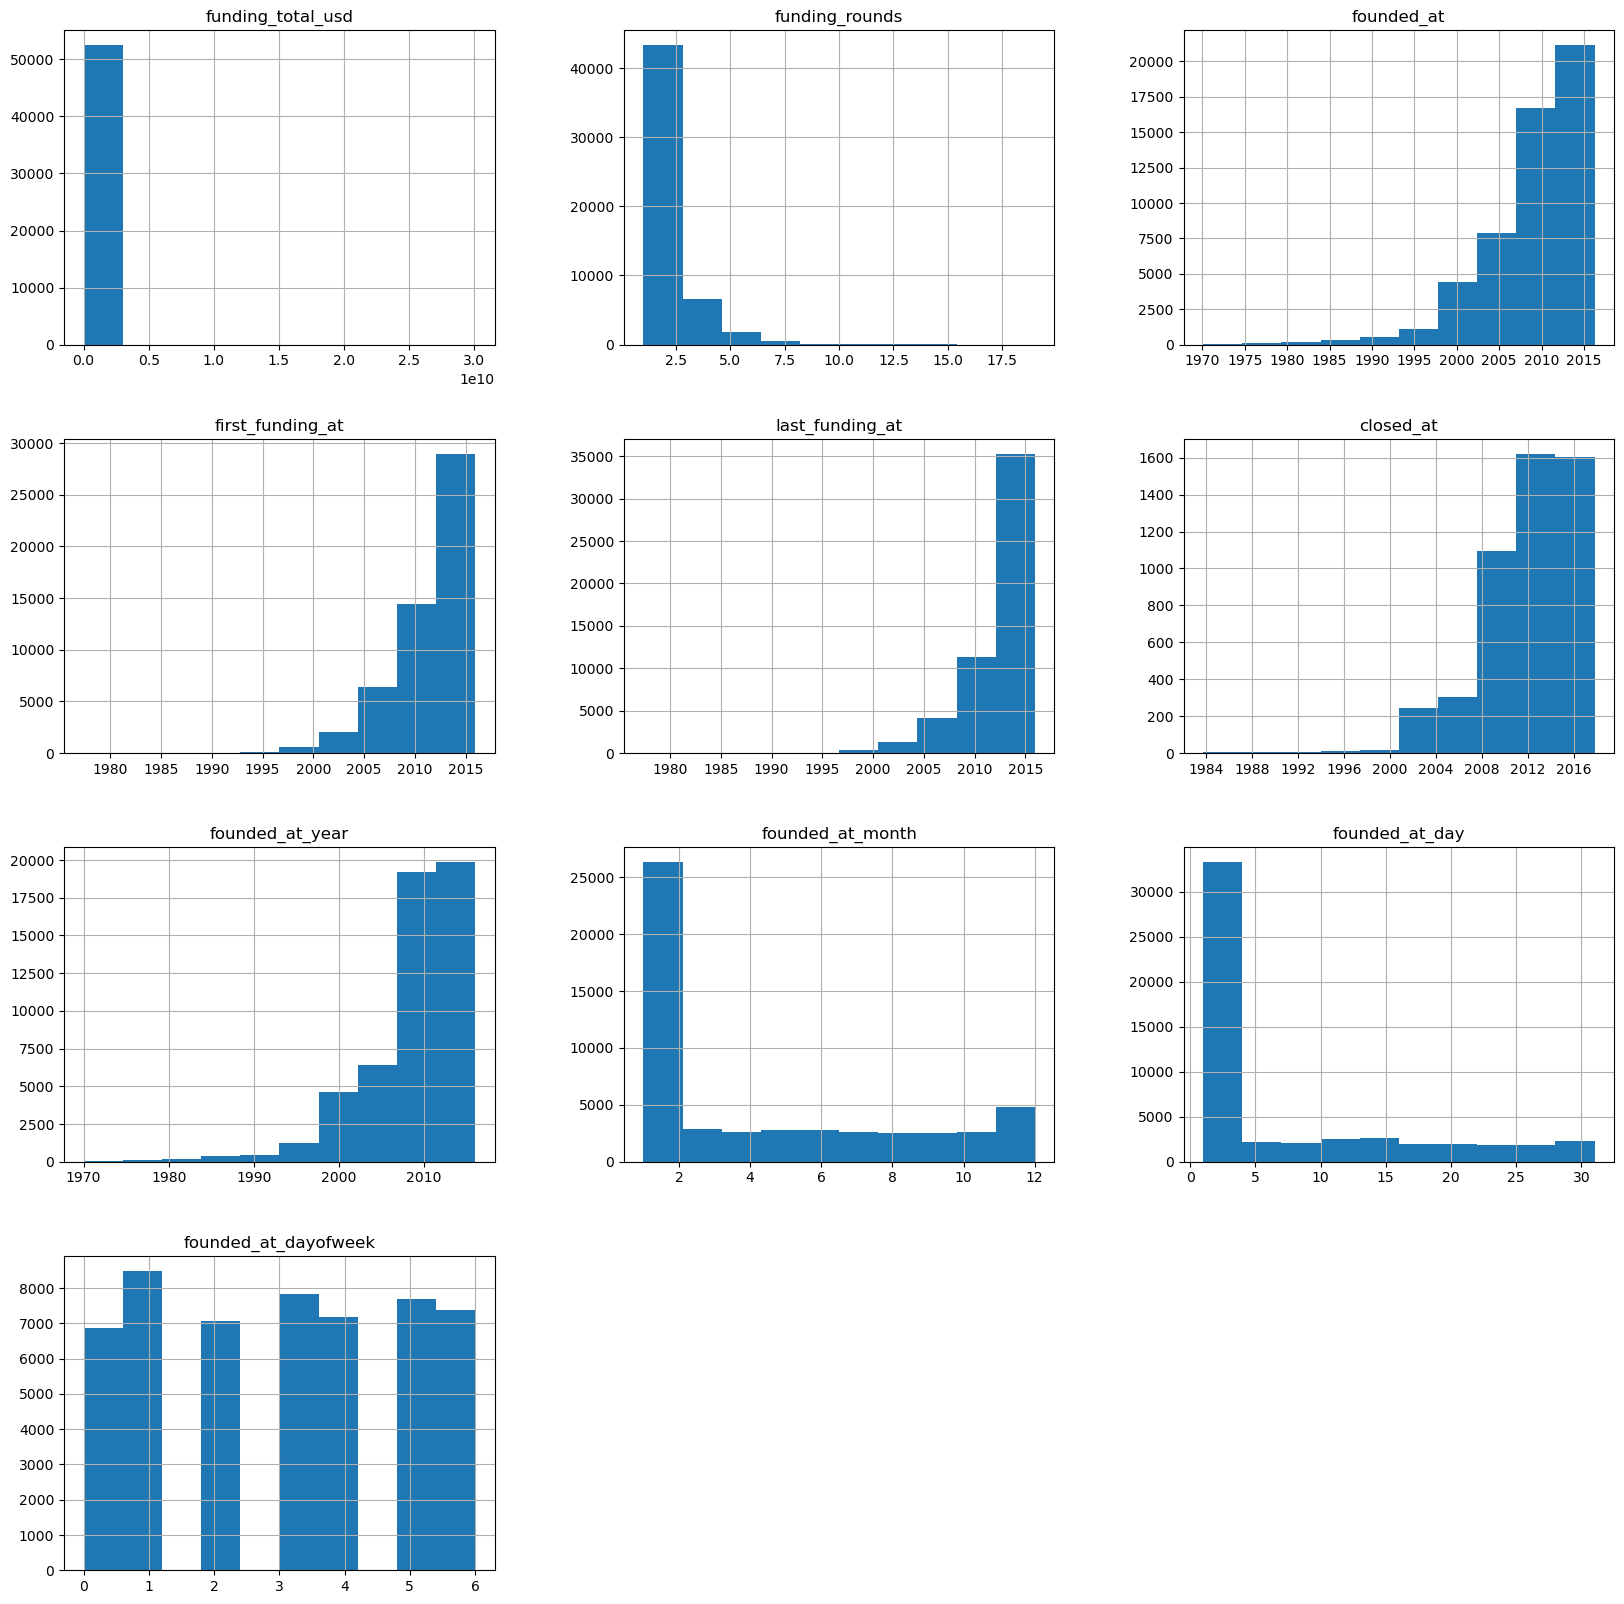

In [105]:
train.hist(figsize=(20, 20));

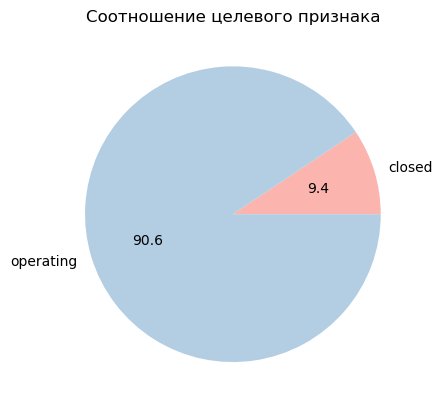

In [106]:
#создаем сводную таблицу, группируем строки по попродам
pivot_pie_status = train.pivot_table(index='status',
                              values='name',
                              aggfunc='count')

#по сводной таблице строим пайчарт
plt.pie(pivot_pie_status['name'], labels=pivot_pie_status.index, autopct='%.1f', colors=plt.cm.Pastel1.colors)
plt.title('Соотношение целевого признака')
plt.show()

### Страны и регионы

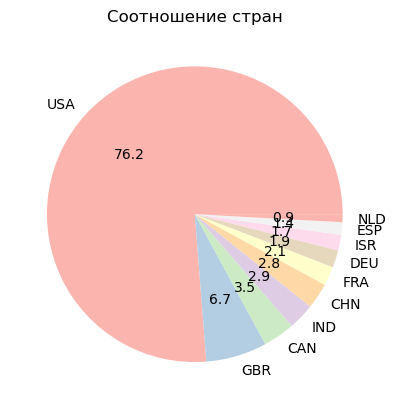

In [108]:
pivot_pie_country = train.pivot_table(index='country_code',
                              values='name',
                              aggfunc='count').sort_values(by=['name'], ascending=False).head(10)

plt.pie(pivot_pie_country['name'], labels=pivot_pie_country.index, autopct='%.1f', colors=plt.cm.Pastel1.colors)
plt.title('Соотношение стран')
plt.show()

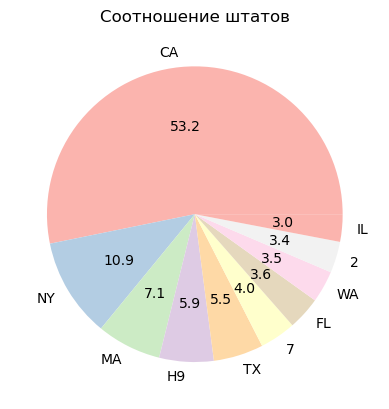

In [109]:
pivot_pie_country = train.pivot_table(index='state_code',
                              values='name',
                              aggfunc='count').sort_values(by=['name'], ascending=False).head(10)

plt.pie(pivot_pie_country['name'], labels=pivot_pie_country.index, autopct='%.1f', colors=plt.cm.Pastel1.colors)
plt.title('Соотношение штатов')
plt.show()

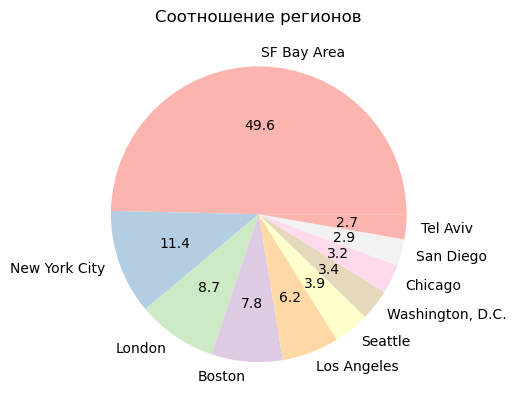

In [110]:
pivot_pie_country = train.pivot_table(index='region',
                              values='name',
                              aggfunc='count').sort_values(by=['name'], ascending=False).head(10)

plt.pie(pivot_pie_country['name'], labels=pivot_pie_country.index, autopct='%.1f', colors=plt.cm.Pastel1.colors)
plt.title('Соотношение регионов')
plt.show()

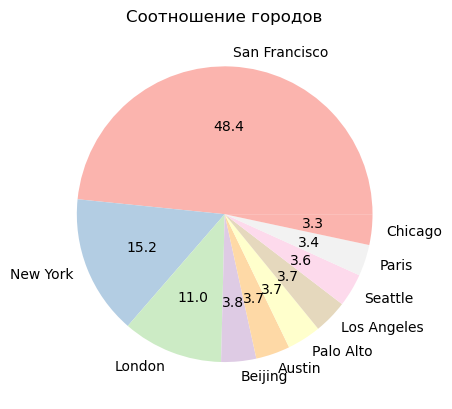

In [111]:
pivot_pie_country = train.pivot_table(index='city',
                              values='name',
                              aggfunc='count').sort_values(by=['name'], ascending=False).head(10)

plt.pie(pivot_pie_country['name'], labels=pivot_pie_country.index, autopct='%.1f', colors=plt.cm.Pastel1.colors)
plt.title('Соотношение городов')
plt.show()

### Категории

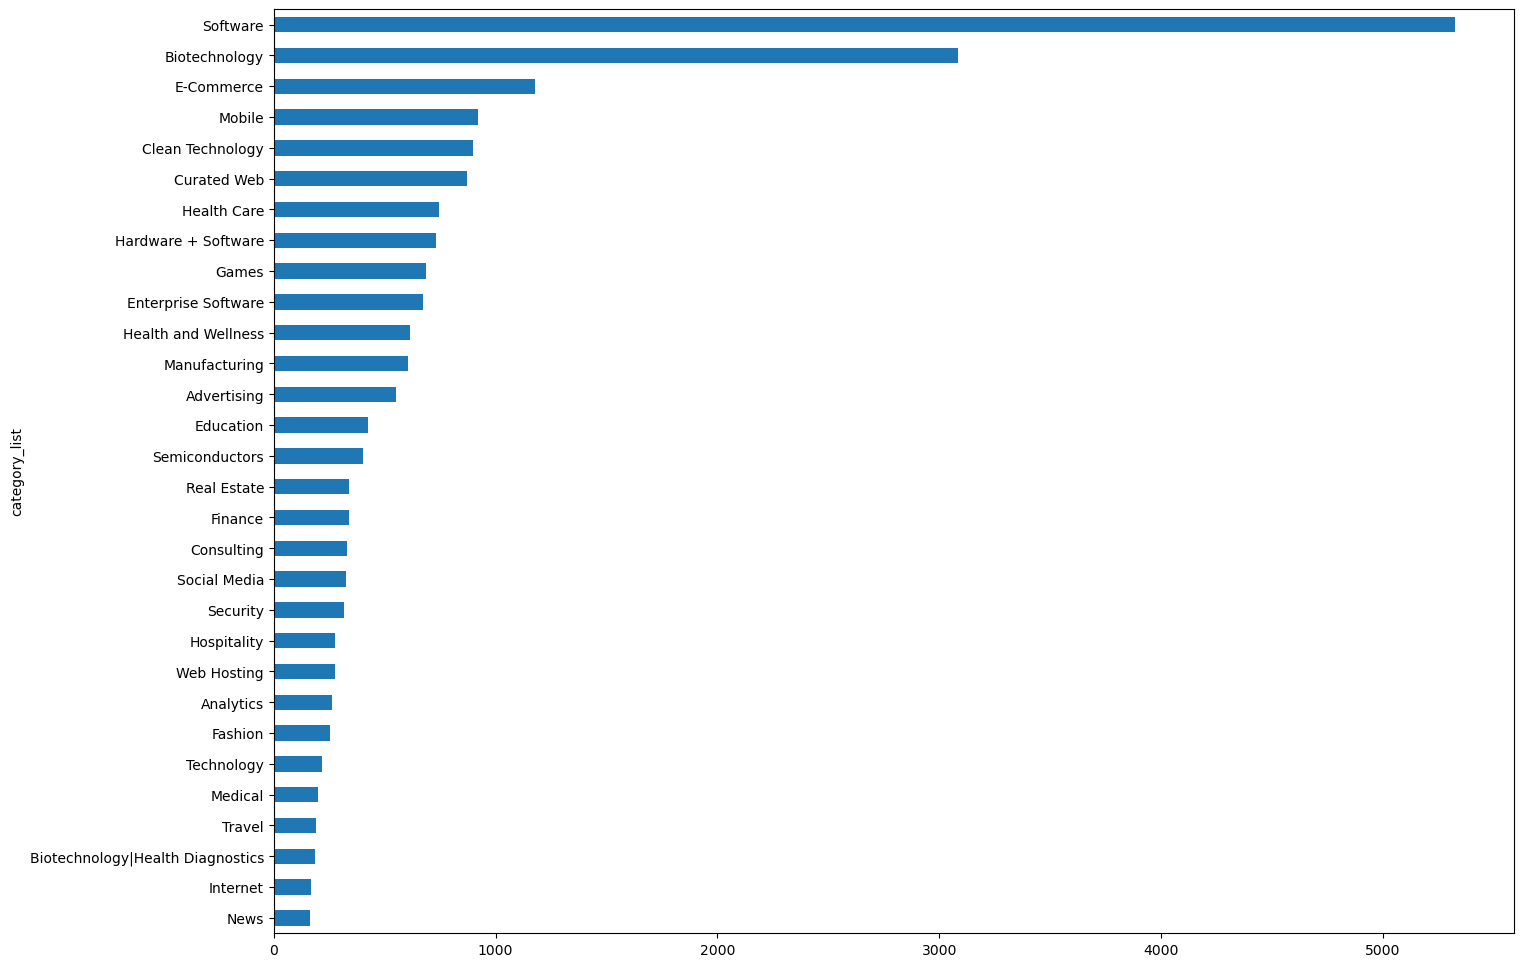

In [113]:
train['category_list'].value_counts(ascending=True).tail(30).plot.barh(figsize = (16, 12))
#plt.title('Распределение по пастбищам')
#plt.xlabel("Число особей")
plt.show()

In [114]:
train['country_code'].value_counts(ascending=False).head(9)

country_code
USA    34679
GBR     3035
CAN     1574
IND     1312
CHN     1284
FRA      948
DEU      861
ISR      772
ESP      626
Name: count, dtype: int64

In [115]:
top_countries = train['country_code'].value_counts(ascending=False).head(9).index

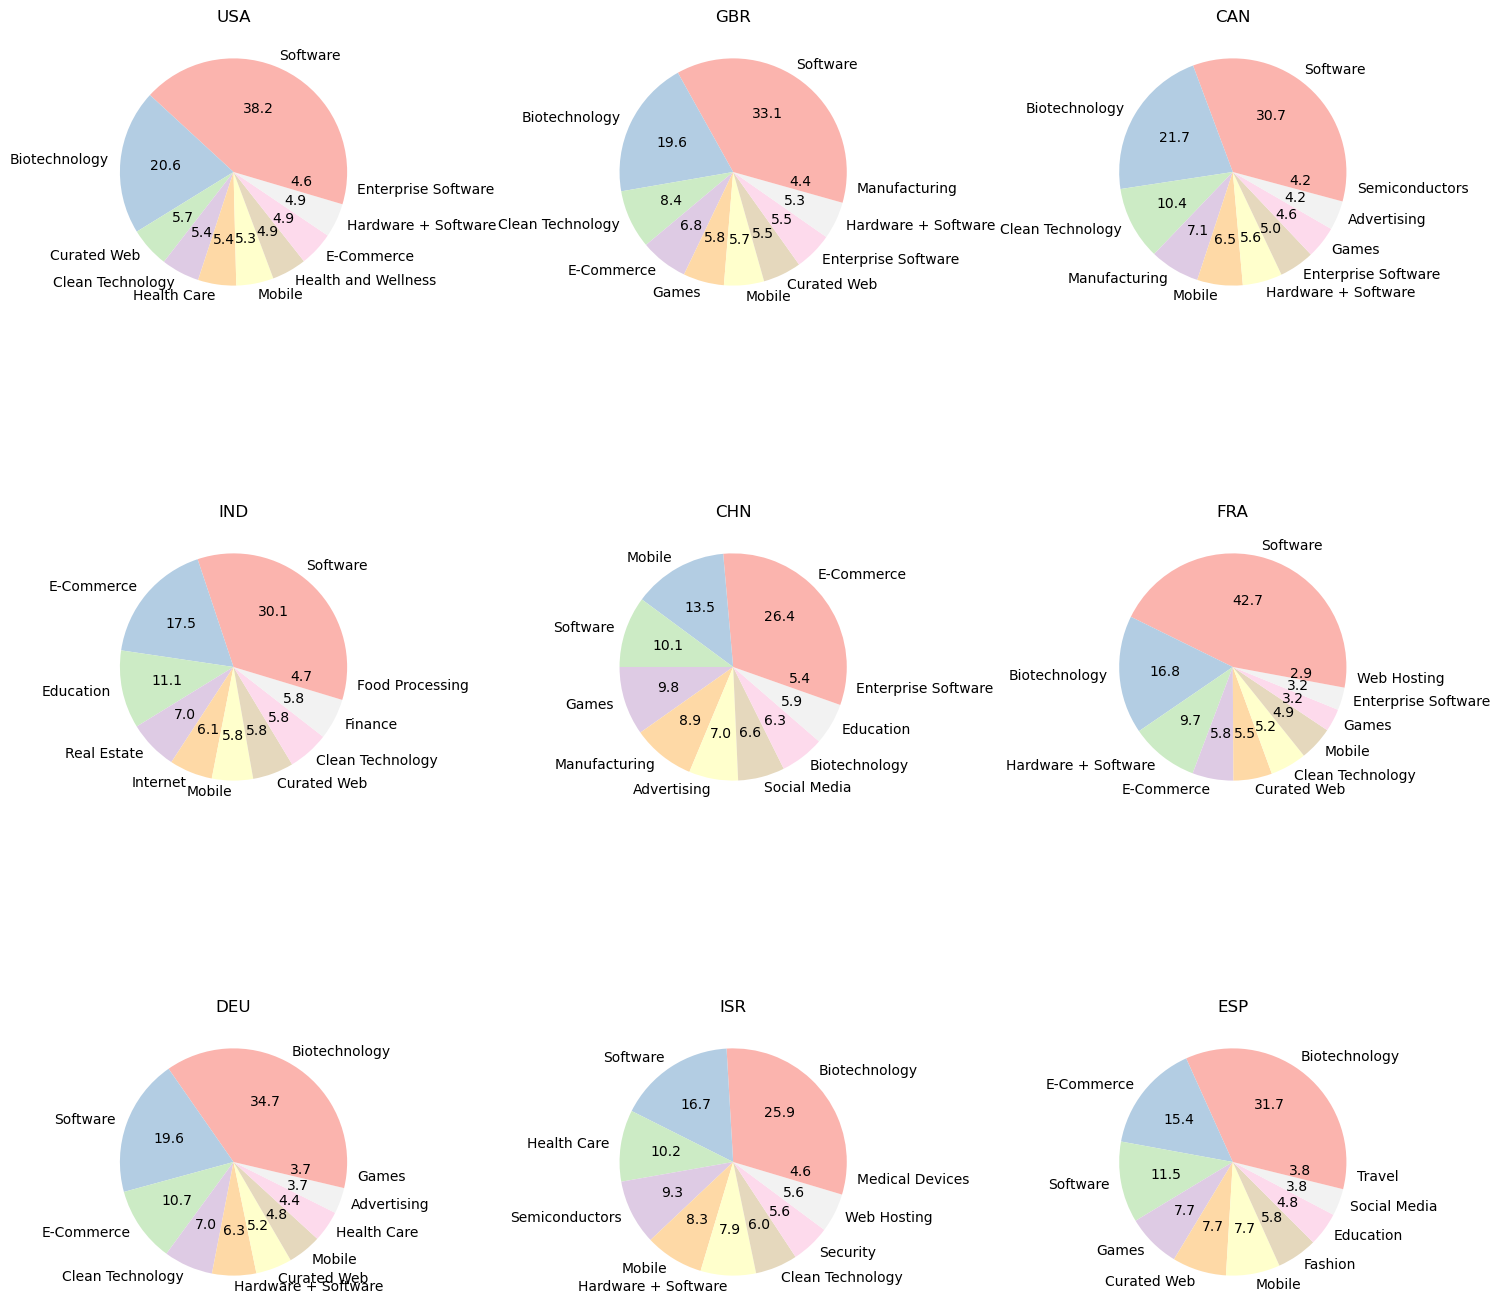

In [116]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for i, country in enumerate(top_countries):
    pivot_pie_country = train[train['country_code'] == country].pivot_table(index='category_list',
                                                                           values='name',
                                                                           aggfunc='count').sort_values(by=['name'],
                                                                                                        ascending=False).head(10)

    axes[i].pie(pivot_pie_country['name'], labels=pivot_pie_country.index, autopct='%.1f', colors=plt.cm.Pastel1.colors)
    axes[i].set_title(f'{country}')

plt.tight_layout()
plt.show()

В каждой стране свое соотношение технологий.

### Объем финансирования

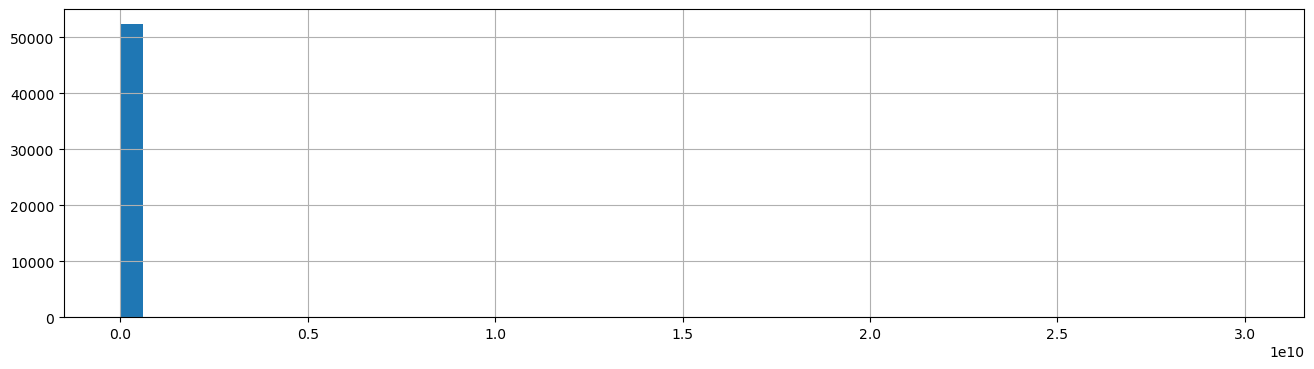

In [119]:
train['funding_total_usd'].hist(figsize = (16, 4), bins=50)
#plt.title('Удой, кг')
#plt.xlabel('кг')
#plt.ylabel('Число особей')
plt.show()

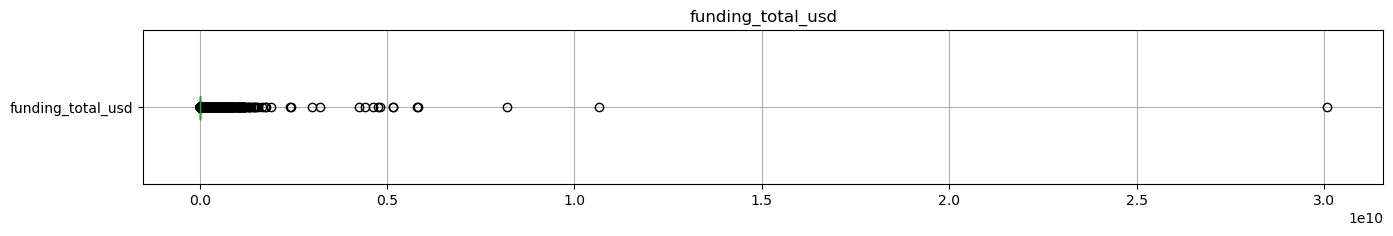

In [120]:
train.boxplot(column="funding_total_usd",figsize = (16, 2), vert=False)
plt.title('funding_total_usd')
plt.show()

In [121]:
display(train[train['funding_total_usd']>5000000000])

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,category_first,founded_at_year,founded_at_month,founded_at_day,founded_at_dayofweek
4557,Uber,Automotive|Design|Limousines|Public Transporta...,8.207450e+09,operating,USA,CA,SF Bay Area,San Francisco,13,2009-03-01,2009-08-01,2015-09-07,NaT,Automotive,2009,3,1,6
5287,Cambridge Technology Partners (CTP),Architecture|Banking|Finance,5.150000e+09,operating,USA,CA,SF Bay Area,San Francisco,2,1990-01-11,1995-01-01,2001-01-01,NaT,Architecture,1990,1,11,3
15976,Clearwire,Internet|Mobile,5.820000e+09,operating,USA,WA,Seattle,Kirkland,6,2003-10-01,2001-12-11,2013-02-27,NaT,Internet,2003,10,1,2
21241,Cambridge Technology Group,Consulting|Product Development Services|Produc...,1.066494e+10,operating,USA,CA,SF Bay Area,San Francisco,1,1988-01-01,2000-01-01,2000-01-01,NaT,Consulting,1988,1,1,4
29080,Charter Communications,Internet|Telecommunications|Television|Video,5.162513e+09,operating,USA,CT,Hartford,Stamford,2,1993-01-01,2009-11-21,2014-09-15,NaT,Internet,1993,1,1,4
36634,Sberbank,Banking|Finance,5.800000e+09,operating,RUS,48,Moscow,Moscow,1,2013-03-20,2014-07-07,2014-07-07,NaT,Banking,2013,3,20,2
39186,Verizon Communications,Communications Infrastructure|Information Tech...,3.007950e+10,operating,USA,NY,New York City,New York,5,1983-10-07,2010-01-26,2014-02-28,NaT,Communications Infrastructure,1983,10,7,4


In [122]:
Q1 = train['funding_total_usd'].quantile(0.25)
Q3 = train['funding_total_usd'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = (Q1 - 1.5 * IQR)
upper_bound = (Q3 + 1.5 * IQR)

In [123]:
without_outlier = train[(train['funding_total_usd'] > lower_bound ) & (train['funding_total_usd'] < upper_bound)]

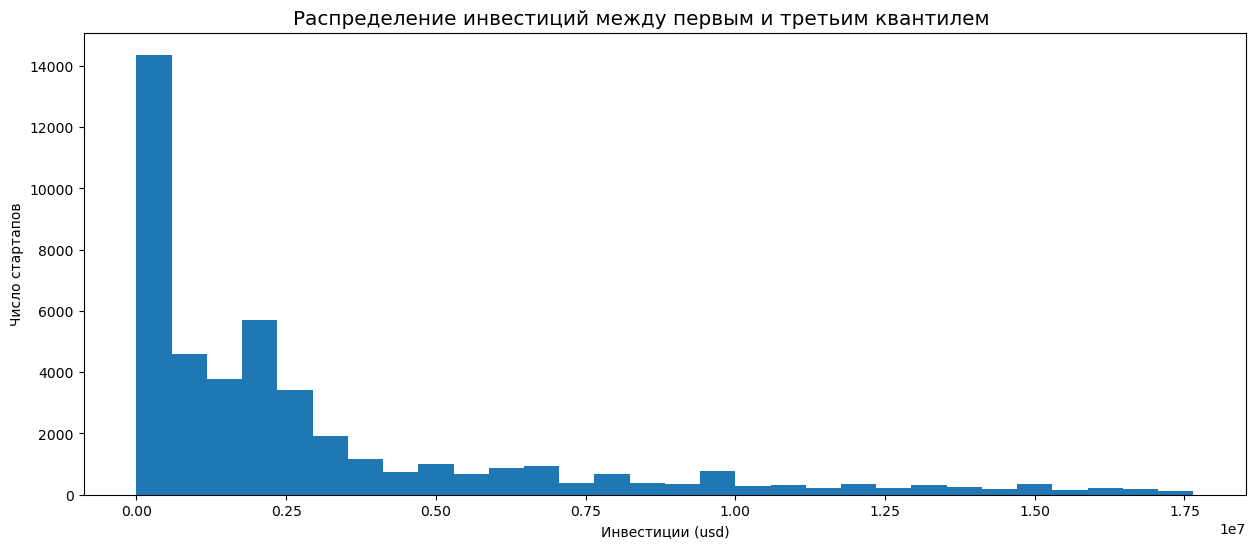

In [124]:
plt.rcParams['figure.figsize'] = 15,6
plt.hist(without_outlier['funding_total_usd'].dropna(), bins=30)

plt.ylabel('Число стартапов')
plt.xlabel('Инвестиции (usd)')
plt.title("Распределение инвестиций между первым и третьим квантилем", fontdict=None, position= [0.48,1.05], size = 'x-large')
plt.show()

Распределение целевого признака показало явный дисбаланс целевого признака 90 к 10 процентам. Таким образом модель может ошибаться склоняясь к преобладающему признаку.

Число стартапов с раундами финансирования сильнопадает после 4-5 раундов.

Почти все стартапы образовались после 1990 года, большая часть после 2000.

Больше всего стартапов закрылось в 2012 году.

В промежутке с 1995 до 2000 начался резкий рост количества стартапов.

Дату основания стартапа как правило выставляют на ровную дату 01.01. Остальные месяцы и дни, дни недели распределены одинаково.

Среди стран большой перевес у USA 76% (больше всего стартапов в штате Калифорния 53%, SF Bay Area, San Francisco). 

Великобритания 7%, Канада 3,5%, Индия 2,9%, Китай 2.8%. 

Больше всего стартапов в категории Software, Biotechnology, E-commerce, Mobile, Games, Education. Хотя в каждой стране свое распределение категорий, эти категории лидируют везде.
Большая часть стартапов получает минимальные инвестиции. При этом существуют выбросы известные на весь мир стартапы типа Убер. Инвестиции в такие стартапы превышают 5 000 000 000 долларов и они все действующие. Не удаляем их.

## Разработка новых синтетических признаков

### lifetime

В тестовой выборке отсутствует столбец с датой закрытия, но есть столбец с длительностью жизни. Создадим такой столбец в тренировочном датафрейме.

In [129]:
train.columns

Index(['name', 'category_list', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'first_funding_at', 'last_funding_at', 'closed_at', 'category_first',
       'founded_at_year', 'founded_at_month', 'founded_at_day',
       'founded_at_dayofweek'],
      dtype='object')

In [130]:
test.columns

Index(['name', 'category_list', 'funding_total_usd', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'first_funding_at',
       'last_funding_at', 'lifetime', 'category_first'],
      dtype='object')

In [131]:
train['last_date'] = train['closed_at']
train[['last_date','closed_at']].head(25)

,last_date,closed_at
0,NaT,NaT
1,NaT,NaT
2,NaT,NaT
3,NaT,NaT
4,NaT,NaT
5,NaT,NaT
6,NaT,NaT
7,NaT,NaT
8,NaT,NaT
9,NaT,NaT


In [132]:
train['last_date'] = train['last_date'].fillna('2018-01-01')
train[['last_date','closed_at']].head(25)

,last_date,closed_at
0,2018-01-01,NaT
1,2018-01-01,NaT
2,2018-01-01,NaT
3,2018-01-01,NaT
4,2018-01-01,NaT
5,2018-01-01,NaT
6,2018-01-01,NaT
7,2018-01-01,NaT
8,2018-01-01,NaT
9,2018-01-01,NaT


In [133]:
train['lifetime'] = (train['last_date'] - train['founded_at']).dt.days
train[['founded_at', 'last_date', 'lifetime', 'closed_at']].head(5)

,founded_at,last_date,lifetime,closed_at
0,2009-10-17,2018-01-01,2998,NaT
1,2005-01-01,2018-01-01,4748,NaT
2,2006-01-01,2018-01-01,4383,NaT
3,2004-01-01,2018-01-01,5114,NaT
4,2010-05-12,2018-01-01,2791,NaT


In [134]:
test['lifetime']

0        3501
1        2717
2        1295
3        4748
4        6209
         ... 
13120    2267
13121    2192
13122    2922
13123    1386
13124    5479
Name: lifetime, Length: 13125, dtype: int64

### funding dates

In [136]:
train['first_funding_at_year'] = train['first_funding_at'].dt.year
train['first_funding_at_month'] = train['first_funding_at'].dt.month
train['first_funding_at_day'] = train['first_funding_at'].dt.year
train['first_funding_at_dayofweek'] = train['first_funding_at'].dt.year

train['last_funding_at_year'] = train['last_funding_at'].dt.year
train['last_funding_at_month'] = train['last_funding_at'].dt.month
train['last_funding_at_day'] = train['last_funding_at'].dt.year
train['last_funding_at_dayofweek'] = train['last_funding_at'].dt.year

In [137]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      13125 non-null  object        
 2   funding_total_usd  13125 non-null  float64       
 3   country_code       13125 non-null  object        
 4   state_code         13125 non-null  object        
 5   region             13125 non-null  object        
 6   city               13125 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
 11  category_first     12534 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(2), object(7)
memory usage: 1.2+ MB


In [138]:
test['first_funding_at_year'] = test['first_funding_at'].dt.year
test['first_funding_at_month'] = test['first_funding_at'].dt.month
test['first_funding_at_day'] = test['first_funding_at'].dt.year
test['first_funding_at_dayofweek'] = test['first_funding_at'].dt.year

test['last_funding_at_year'] = test['last_funding_at'].dt.year
test['last_funding_at_month'] = test['last_funding_at'].dt.month
test['last_funding_at_day'] = test['last_funding_at'].dt.year
test['last_funding_at_dayofweek'] = test['last_funding_at'].dt.year

### city_is_capital

In [140]:
capitals = ['Bern', 'Washington, D.C.', 'London', 'Moscow', 'Madrid', 'Paris', 'Stockholm', 'New Delhi', 'Seoul',
            'Canberra', 'Taipei', 'Beijing', 'Budapest', 'Ottawa', 'Helsinki', 'Brasília', 'Cairo', 'Lisbon',
            'Jerusalem', 'Santiago', 'Bratislava', 'Amsterdam', 'Buenos Aires', 'Abu Dhabi', 'Tokyo', 'Dublin',
            'Berlin', 'Beirut', 'Tallinn', 'Jakarta', 'Brussels', 'Mexico City', 'Copenhagen', 'Rome', 'Athens',
            'Bucharest', 'Ankara', 'Singapore', 'Riyadh', 'Kuala Lumpur', 'Lagos', 'Doha', 'Hanoi', 'Sofia',
            'Accra', 'Kampala', 'Amman', 'Vienna', 'Islamabad', 'Wellington', 'Hong Kong', 'Pretoria', 'Riga',
            'Oslo', 'Zagreb', 'Caracas', 'Lima', 'Luxembourg', 'Ljubljana', 'Warsaw', 'Manila', 'Managua',
            'Prague', 'Reykjavik', 'Panama City', 'Montevideo', 'Dhaka', 'Monaco', 'Guatemala City', 'Bangkok',
            'Port of Spain', 'Kyiv', 'Nairobi', 'San José', 'Algiers', 'Vilnius', 'George Town', 'Port Louis',
            'Minsk', 'San Salvador', 'Bogotá', 'Valletta', 'Ramallah', 'Belmopan', 'Nicosia', 'Naypyidaw',
            'Skopje', 'Phnom Penh', 'Gibraltar', 'Belgrade', 'Santo Domingo', 'Gaborone', 'Gustavia', 'Asunción',
            'Hamilton', 'Dodoma', 'Vaduz', "Saint George's", 'Tashkent', 'Tbilisi', 'Dakar', 'Tirana', 'Quito',
            'Maputo', 'Colombo', 'Vientiane', 'Tunis', 'Tegucigalpa', 'Harare', 'Nassau', 'Chisinau', 'Marigot',
            'Manama', 'Baku', 'Rabat', 'Kuwait City', 'Tehran', 'Saint Peter Port', 'Basseterre', 'San Juan',
            'Muscat', 'Nur-Sultan', 'Kingston', 'Kathmandu', 'Yerevan', 'Lomé', 'Kigali', 'Bandar Seri Begawan',
            'Saint Helier', 'Mogadishu', 'Yaoundé', 'Podgorica', 'Victoria', 'Lusaka']

In [141]:
train['city_is_capital'] = train['city'].apply(lambda x: 1 if x in capitals else 0)
train[['city','city_is_capital']].head(3)

,city,city_is_capital
0,Zürich,0
1,Redwood City,0
2,San Jose,0


In [142]:
test['city_is_capital'] = test['city'].apply(lambda x: 1 if x in capitals else 0)
test[['city','city_is_capital']].head(3)

,city,city_is_capital
0,nocity,0
1,Humboldt,0
2,Esch-sur-alzette,0


### funding_days_difference

In [144]:
train.select_dtypes(include=['datetime', 'datetime64', 'timedelta', 'timedelta64']).columns

Index(['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at',
       'last_date'],
      dtype='object')

In [145]:
test.select_dtypes(include=['datetime', 'datetime64', 'timedelta', 'timedelta64']).columns

Index(['first_funding_at', 'last_funding_at'], dtype='object')

In [146]:
train['funding_days_difference'] = (train['last_funding_at'] - train['first_funding_at']).dt.days
train['funding_days_difference'] = train['funding_days_difference'].astype('int64')

test['funding_days_difference'] = (test['last_funding_at'] - test['first_funding_at']).dt.days
test['funding_days_difference'] = test['funding_days_difference'].astype('int64')

train[['funding_days_difference', 'first_funding_at', 'last_funding_at']]

,funding_days_difference,first_funding_at,last_funding_at
0,1310,2011-05-01,2014-12-01
1,1393,2010-05-04,2014-02-25
2,681,2012-08-20,2014-07-02
3,1051,2011-09-01,2014-07-18
4,0,2012-02-01,2012-02-01
...,...,...,...
52511,0,2014-03-01,2014-03-01
52512,0,2014-03-07,2014-03-07
52513,566,2009-06-14,2011-01-01
52514,1918,1998-11-30,2004-03-01


## Проверка на мультиколлинеарность

Для подсчета корреляций закодируем категории

In [149]:
# Создание экземпляра OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Кодирование столбца 'status'
status_encoded = encoder.fit_transform(train[['status']])
status_encoded_df = pd.DataFrame(status_encoded, columns=encoder.get_feature_names_out(['status']))

# Объединение закодированных столбцов с исходным DataFrame
train_encoded = pd.concat([train, status_encoded_df], axis=1)

# Удаление исходных столбцов 'status' и 'continent'
train_encoded.drop(['status'], axis=1, inplace=True)

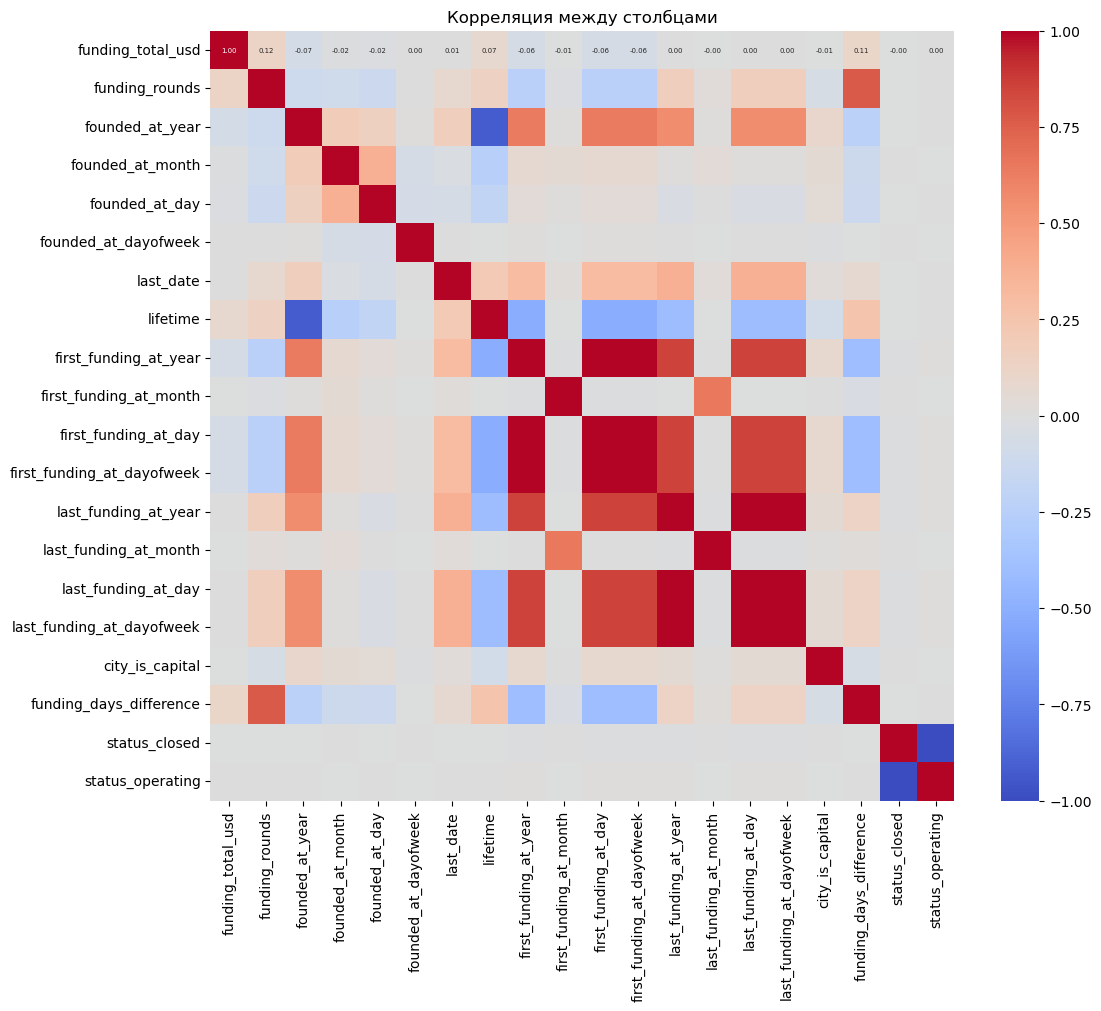

In [150]:
columns_to_drop = ['name',
                   'category_list',
                   'category_first',
                   'country_code',
                   'state_code',
                   'region',
                   'city',
                   'founded_at',
                   'first_funding_at',
                   'last_funding_at',
                   'closed_at']

corr_matrix_train = train_encoded.drop(columns=columns_to_drop).corr()

# Визуализация корреляции пропусков
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_train, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 5})
plt.title('Корреляция между столбцами')
plt.show()

Есть высокие значения корреляции. Чтобы избежать мультиколлинеарности, добавим в список для удаления столбцы:

In [152]:
columns_to_drop = ['name',
                   'category_list',
                   'category_first',
                   'country_code',
                   'state_code',
                   'region',
                   'city',
                   'founded_at',
                   'first_funding_at',
                   'last_funding_at',
                   'closed_at']

## Отбор финального набора обучающих признаков

In [154]:
cols = ['funding_total_usd', 
        'country_code',
        'city_is_capital',
        'funding_rounds', 
        'lifetime', 
        'first_funding_at_year', 
        'first_funding_at_month', 
        'funding_days_difference',
        'category_list']

In [176]:
RANDOM_STATE = 42

In [156]:
X_train = train[cols]
X_test = test[cols]

y_train = train['status']
y_test = sample['status']

In [157]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [158]:
ohe_columns = ['country_code',
               'city_is_capital',
               'category_list']

num_columns = ['funding_total_usd', 
               'funding_rounds',
               'lifetime',
               'first_funding_at_month',
               'first_funding_at_year',
               'funding_days_difference']

## Выбор и обучение моделей

In [160]:
# пайплайн для подготовки признаков:
ohe_pipe = Pipeline(
    [
        ('ohe', OneHotEncoder(drop='first',
                              handle_unknown='ignore',
                              sparse_output=False))
    ]
)

num_pipe = Pipeline([
    ('scaler', MinMaxScaler())
])


In [161]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe_pipe, ohe_columns),
        ('num', num_pipe, num_columns)
    ],
    remainder='passthrough'
)

In [162]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [163]:
param_distributions = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели CatBoostClassifier()
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, silent=True, task_type='GPU')],
        'models__depth': range(2, 5),
        'models__iterations': [50, 100],
        'models__learning_rate': [0.01, 0.1],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [164]:
'''
# с регуляризацией -- показало меньшую оценку на трейне и на тесте
param_distributions = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__min_samples_split': [2, 5, 10],
        'models__min_samples_leaf': [1, 2, 4],
        'models__ccp_alpha': [0.0, 0.01, 0.1],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, silent=True, task_type='GPU')],
        'models__depth': range(2, 5),
        'models__l2_leaf_reg': [1, 3, 5],
        'models__random_strength': [0.5, 1, 2],
        'models__bagging_temperature': [0, 1, 2],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]
'''

"\n# с регуляризацией -- показало меньшую оценку на трейне и на тесте\nparam_distributions = [\n    {\n        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],\n        'models__max_depth': range(2, 5),\n        'models__min_samples_split': [2, 5, 10],\n        'models__min_samples_leaf': [1, 2, 4],\n        'models__ccp_alpha': [0.0, 0.01, 0.1],\n        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']\n    },\n    {\n        'models': [CatBoostClassifier(random_state=RANDOM_STATE, silent=True, task_type='GPU')],\n        'models__depth': range(2, 5),\n        'models__l2_leaf_reg': [1, 3, 5],\n        'models__random_strength': [0.5, 1, 2],\n        'models__bagging_temperature': [0, 1, 2],\n        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']\n    }\n]\n"

In [165]:
joblib.parallel_backend('threading')

In [166]:
#запускаем таймер
start = time.time()

random_search = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_distributions,
    n_iter=10,  # количество итераций поиска
    cv=5,
    scoring='f1',
    verbose=10,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

random_search.fit(X_train, y_train_encoded)

search_time = (time.time() - start)/60
print(f'Время поиска: {search_time:.1f} мин')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START models=<catboost.core.CatBoostClassifier object at 0x00000261CEFD7290>, models__depth=4, models__iterations=100, models__learning_rate=0.1, preprocessor__num=MinMaxScaler()
[CV 2/5; 1/10] START models=<catboost.core.CatBoostClassifier object at 0x00000261CEFD7290>, models__depth=4, models__iterations=100, models__learning_rate=0.1, preprocessor__num=MinMaxScaler()
[CV 3/5; 1/10] START models=<catboost.core.CatBoostClassifier object at 0x00000261CEFD7290>, models__depth=4, models__iterations=100, models__learning_rate=0.1, preprocessor__num=MinMaxScaler()
[CV 4/5; 1/10] START models=<catboost.core.CatBoostClassifier object at 0x00000261CEFD7290>, models__depth=4, models__iterations=100, models__learning_rate=0.1, preprocessor__num=MinMaxScaler()
[CV 5/5; 1/10] START models=<catboost.core.CatBoostClassifier object at 0x00000261CEFD7290>, models__depth=4, models__iterations=100, models__learning_rate=0.1, pr

C:\Users\User\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5; 3/10] END models=DecisionTreeClassifier(random_state=42), models__max_depth=2, models__max_features=2, preprocessor__num=StandardScaler();, score=0.951 total time=  12.7s
[CV 3/5; 5/10] END models=DecisionTreeClassifier(random_state=42), models__max_depth=2, models__max_features=3, preprocessor__num=passthrough;, score=0.951 total time=  11.1s


C:\Users\User\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5; 8/10] END models=DecisionTreeClassifier(random_state=42), models__max_depth=3, models__max_features=3, preprocessor__num=StandardScaler();, score=0.951 total time=  11.6s


C:\Users\User\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
47 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_on

Время поиска: 4.6 мин


## Итоговая оценка качества предсказания лучшей модели

In [168]:
print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', random_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['country_code',
                                                   'city_is_capital',
                                                   'category_list']),
                                                 ('num', MinMaxScaler(),
                                                  ['funding_total_usd',
                                                   'funding_rounds', 'lifetime',
    

In [169]:
y_pred = random_search.predict(X_test)
y_pred_encoded = label_encoder.inverse_transform(y_pred)

print(f'Метрика F1 на тестовой выборке: {f1_score(y_test_encoded, y_pred)}')

C:\Users\User\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Метрика F1 на тестовой выборке: 0.6526528657335959


In [170]:
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [171]:
y_pred_encoded

array(['operating', 'operating', 'operating', ..., 'operating',
       'operating', 'operating'], dtype=object)

In [172]:
y_test_encoded

array([0, 1, 0, ..., 0, 1, 1])

## Анализ важности признаков

Выведем на экран график важности признаков обученной модели. Отсортируем признаки по убыванию значимости.

Построим столбчатую диаграмму с помощью SHAP, покажем средний вклад каждого признака в результат работы модели.

Размерности shap_values: (13125, 22236)
Количество признаков после преобразования: 22236


C:\Users\User\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


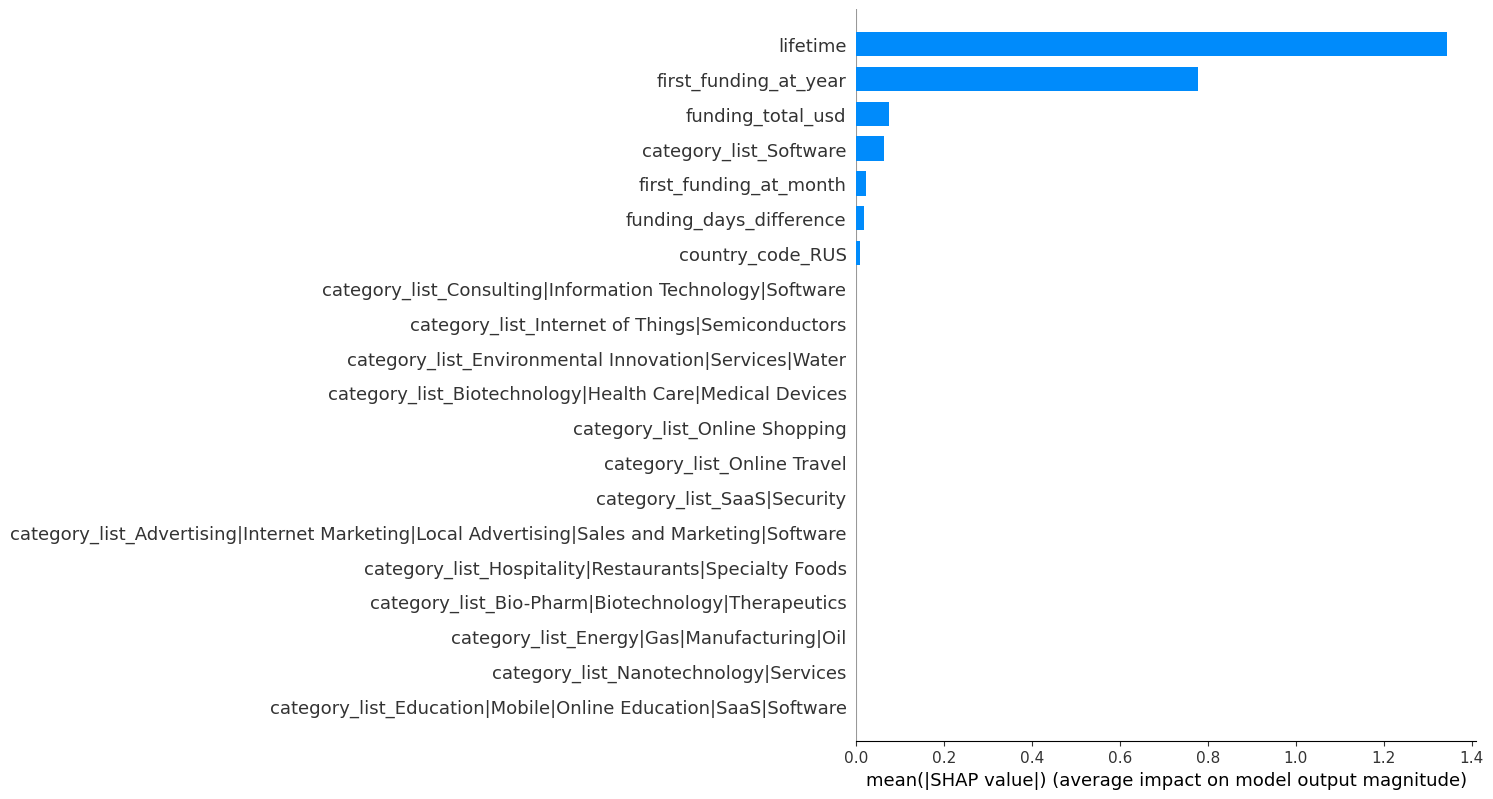

In [180]:
# Выполняем преобразование данных с помощью обученного пайплайна
X_train_transformed = random_search.best_estimator_.named_steps['preprocessor'].transform(X_train)

# Получаем имена новых признаков после преобразования данных
ohe_pipe = random_search.best_estimator_.named_steps['preprocessor'].named_transformers_['ohe']
transformed_feature_names = ohe_pipe.named_steps['ohe'].get_feature_names_out(ohe_columns)

# Объединяем полученные имена признаков
all_feature_names = list(transformed_feature_names) + num_columns

# Проверяем размерности SHAP значений
print("Размерности shap_values:", shap_values.shape)
print("Количество признаков после преобразования:", len(all_feature_names))

# Строим столбчатую диаграмму важности признаков с правильными именами
shap.summary_plot(shap_values, X_test_transformed, feature_names=all_feature_names, plot_type="bar")

# Итог

С использованием пайплайна была получена лучшая модель с параметрами

In [188]:
print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['country_code',
                                                   'city_is_capital',
                                                   'category_list']),
                                                 ('num', MinMaxScaler(),
                                                  ['funding_total_usd',
                                                   'funding_rounds', 'lifetime',
    

И лучшей метрикой на тренировочном датасете 0.95. Корреляционным анализом исключили переобучение. На тестовом датасете добились максимальной оценки 0.67

Анализ признаков показал наиболее важными признаками признаки категорий, стран и объема финансирования. После кодирования наибольший вес имели признаки: lifetime, год создания стартапа (с первым признаком имеют высокую корреляцию), объем инвестирования. Даже месяц образования и разница между датами инвестирования имеет небольшое значение.